<a href="https://colab.research.google.com/github/cdr6934/LymphnodePathologyModel/blob/main/Lymphnode_Pathology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Install

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'histopathologic-cancer-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F11848%2F862157%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240423%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240423T024755Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D336b2f51891051b7e1f4a39e6a30544af3765b89984053fe2c8d9ac40aaaa49caac90f65fce84cfc8e2cc53a2335a1d0d8b8bd20ad02c695e4656be1580b4d421ff3e015b01304b5f7af6f487220db5f0707ec00db4d6094f6a43cbc7b4dcaaa2eabbbef02024831ca30c0edc1119822aefc9ec269c3010012b69398a587a4aa55c1379de361f2d1a83647b608fa49dc161406138de57aa95de4a913af08b714b5d4f975750a1d828fb63bdb34187ea4da32bf7f71487a6be642c42431f064cdbb7cca89465999807ce8422c9a2794112b63f160eae1c45390b0e5bff7f956e0db90e0d190089632c7839cc4538214da1f51711df5fe7d3322690ca316d6ac77'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# CNN Binary Image Classification
4/22/2024


## Introduction
The goal of this project is to develop a binary CNN classifier using the PCam dataset to accurately identify the presence or absence of metastatic tissue in histopathologic scans of lymph node sections. Metastatic tissue detection plays a crucial role in cancer diagnosis and staging, and automating this process using deep learning techniques can assist pathologists in making faster and more accurate diagnoses.

The PCam dataset consists of histopathologic scans of lymph node sections, where each image is labeled as either containing metastatic tissue or not. The dataset provides a challenging task due to the high variability in the appearance of metastatic tissue and the presence of complex background structures.


### Data


The PatchCamelyon (PCam) dataset is a specialized dataset often used in medical imaging, particularly in the field of pathology. It's a benchmark dataset derived from the Camelyon16 Challenge held at the International Symposium on Biomedical Imaging (ISBI). The dataset is specifically designed for developing and evaluating machine learning models that can detect metastatic tissue in histopathologic scans of lymph node sections, a critical task in diagnosing breast cancer.

As far as the data goes,each image collection is a 32x32 pixel region of a patch that contain tissue samples from patient biopsies in order to diagnose malignant .

The dataset PathCamelyon (PCam) (slightly different than the original as it does not have duplicated images). There around 220,025 images in the dataset. In this case, the annotations are a binary classification problem.

* Positive class (1) indicates that the patch contains at least one pixel of tumor tissue.
* Negative class (0) means there are no tumor tissues in the patch.

## Exploratory Data Analysis (EDA)

The first thing to be done is to glance over the data and consider what will provide the models the best information. For one we will want to understand the class count, and then the distribution between the classes in order to understand how balanced the dataset is. Then we will want to take a glance at the images in order to understand the data, what do the images look like and how might they appear different. Without some context, it makes it difficult to provide value without giving some thought into the images.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


# Torch
import torch
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision.datasets import ImageFolder
import torch.nn.functional as F

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import cv2
import copy


%matplotlib inline

In [ ]:
annotation_path = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'
data = pd.read_csv(annotation_path)
train_path = '/kaggle/input/histopathologic-cancer-detection/train'
test_path = '/kaggle/input/histopathologic-cancer-detection/test'

#### Data Count
For the
The labels are:
* 0 - no metastic tissue
* 1 - metastic tissue


We see that there are a total of 220025 images in the **training dataset** which we will split out for training on a 20% / 80% split which will be then used to train the graphs below.

For the test dataset, there are 57458 images that we will then test on.


In [ ]:
data['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

In [ ]:
def count_files_fast(directory):
    """Count the number of files in the given directory using os.scandir(), which is faster."""
    with os.scandir(directory) as entries:
        return sum(1 for entry in entries if entry.is_file())

count_files_fast(test_path)

57458

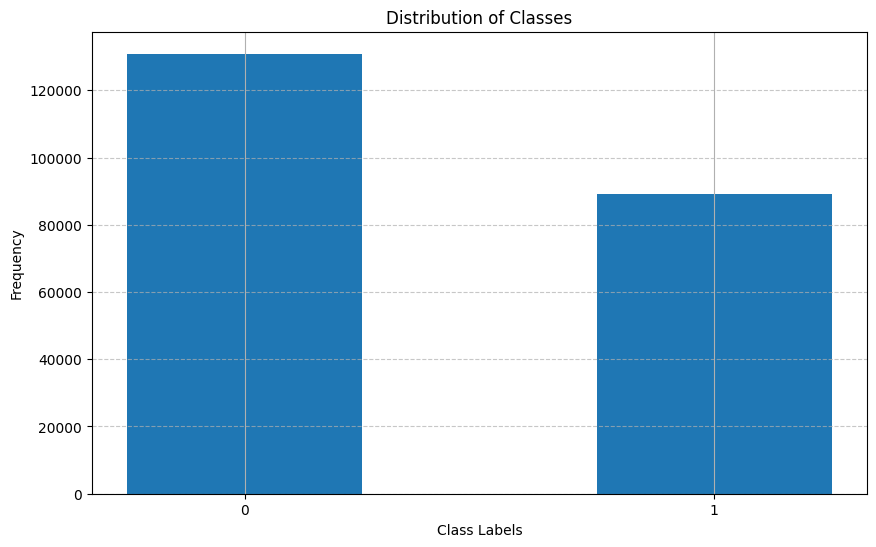

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram of the 'label' column
plt.figure(figsize=(10, 6))
data['label'].hist(bins=range(int(data['label'].min()), int(data['label'].max()) + 2), align='left', rwidth=0.5)
plt.title('Distribution of Classes')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.xticks(range(int(data['label'].min()), int(data['label'].max()) + 1))  # Ensure x-ticks cover all classes
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We see that there is some work that can be doneby trying to level out the class. Right now, we are statistically going to draw on more negative samples than positive ones. This can be avoided by trying to sample an equal number of samples from each of the classes.

In [ ]:
# Reads image
def read_image(path):
    img = cv2.imread(path)
    b,g,r = cv2.split(img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

Text(0, 0.5, 'Tumor tissue samples')

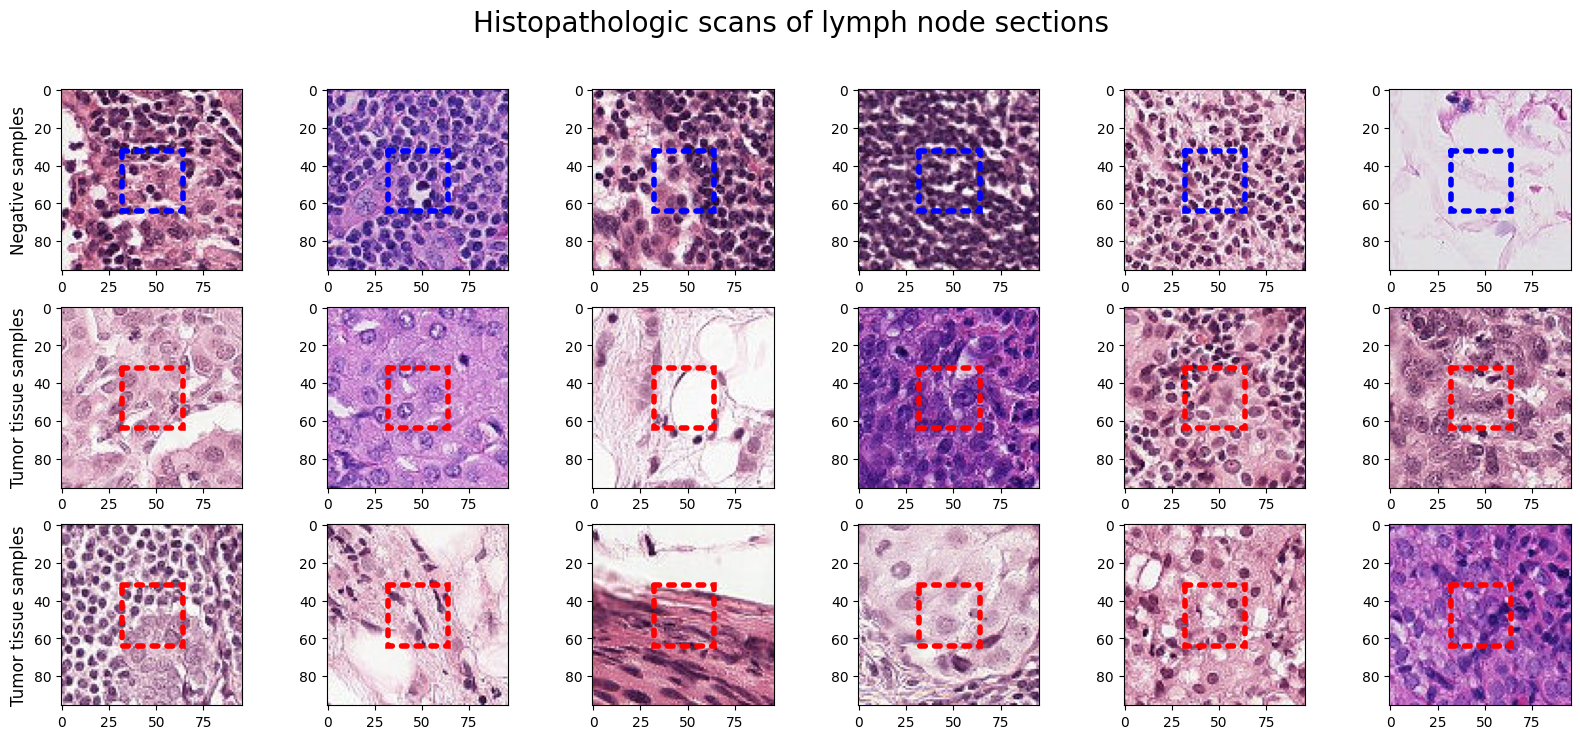

In [ ]:
# random sampling
shuffled_data = shuffle(data)

fig, ax = plt.subplots(3,6, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:6]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(read_image(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:6]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(read_image(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)

for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][7:13]):
    path = os.path.join(train_path, idx)
    ax[2,i].imshow(read_image(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[2,i].add_patch(box)

ax[1,0].set_ylabel('Tumor tissue samples', size='large')
ax[2,0].set_ylabel('Tumor tissue samples', size='large')

Based off of these images, we can visually identify and see the slight differences between the malignant and normal cell populations that we see. In the not malignant images (blue squarese) we see norma size nuclei that have been stained and have a very tight squeeze about them. Whereas when looking at the tumor tissue, we see that the nuclei are definitely much more bloated and diffuse providing insight into what the model will pick up as differences between the images.

## Model Architecture



There are a number of different parameters that can be changed in order to get a good sense of how good a specific architecture will run. There are many more  complex models that can be run, but for the sake of understanding the torch framework and building from scratch, this will help us to better understand the various layers that the tensor will flow through.

Here we have taken and transformed the images to be resized, then they will be randomly flipped and then convered to tensor. Then the image is normalized.

In [ ]:
# Here we will transform the images which will help us
transform = transforms.Compose(
[
    transforms.CenterCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(45),  
    transforms.RandomResizedCrop(50,scale=(0.8,1.0),ratio=(1.0,1.0)),
    transforms.ToTensor()

In [ ]:
img_class_dict = {k:v for k, v in zip(data.id, data.label)}

In [ ]:

# Dataset was easier to build as a class in order to use the dataset
class LymphDataset(Dataset):
    def __init__(self, datafolder, datatype='train', transform = transforms.Compose([transforms.CenterCrop(32),transforms.ToTensor()]), labels_dict={}):
        self.datafolder = datafolder
        self.datatype = datatype
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform
        self.labels_dict = labels_dict
        if self.datatype == 'train':
            self.labels = [labels_dict[i.split('.')[0]] for i in self.image_files_list]
        else:
            self.labels = [0 for _ in range(len(self.image_files_list))]

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder, self.image_files_list[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        img_name_short = self.image_files_list[idx].split('.')[0]

        if self.datatype == 'train':
            label = self.labels_dict[img_name_short]
        else:
            label = 0
        return image, label

In [ ]:
full_dataset = LymphDataset(datafolder=train_path, datatype='train', transform=transform,labels_dict=img_class_dict)
test_dataset = LymphDataset(datafolder=test_path, datatype='test',  transform=transform, labels_dict={})


# Define the size of your validation set
validation_split = 0.2  # e.g., 20% of the dataset goes to validation
num_data = len(full_dataset)
num_val = int(num_data * validation_split)
num_train = num_data - num_val
batch_size = 32

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [num_train, num_val])

train_indices = np.random.choice(len(train_dataset), 10000, replace=False)  # Randomly select 100 indices
train_subset_dataset = Subset(train_dataset, train_indices)

val_indices = np.random.choice(len(val_dataset), 10000, replace=False)  # Randomly select 100 indices
val_subset_dataset = Subset(val_dataset, val_indices)

# Currently a subset of the complete dataset
val_dataloader = DataLoader(val_subset_dataset, batch_size=batch_size, shuffle=False)
train_dataloader = DataLoader(train_subset_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, shuffle=False)

In [ ]:
# Used to validate the CNN
def validate(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradients needed for validation, reduces memory consumption
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    accuracy = 100 * correct / total
    return val_loss, accuracy

## Simple CNN
This is simply a very basic two layered architecture. This is the simplest form of a network that can be produced.

In this implementation, the CNN consists of a single convolutional layer followed by a ReLU activation function and a max pooling layer. The convolutional layer has 3 input channels (typically for RGB images), 32 output channels, and a kernel size of 3. The ReLU activation introduces non-linearity to the network, allowing it to learn more complex patterns. The max pooling layer downsamples the spatial dimensions of the feature maps, reducing the computational burden and providing translation invariance.

After the convolutional layer, the feature maps are flattened into a 1D tensor, which is then passed through a fully connected layer. The fully connected layer maps the learned features to the desired output size, which is set to 100 in this case.

In [ ]:
# Network Architecture
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # 3 input channels, 32 output, kernel size 3
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer
        self.fc1 = nn.Linear(32 * 128 * 128, 100)  # Adjust size according to your input/output

    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        num_features = x.size(1)*x.size(2)*x.size(3)
        x = x.view(-1,num_features)  # Flatten the tensor for the fully connected layer

        return x

In order to make the iteration a bit easier, I've taken the training and validation and put them into a function in order to more easily iterate over a dataset.

In [ ]:

def SimpleCNNRun( num_epochs=20, lr=0.01, betas=(0.9, 0.999), optimizer):
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }
    # Assume the model is already defined
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas)

    for epoch in range(num_epochs):
        train_loss = 0
        correct = 0
        total = 0

        # Training part as detailed previously
        model.train()
        for i, (images, labels) in  enumerate(train_dataloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # for train
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


        train_loss /= len(train_dataloader)
        train_accuracy = 100 * correct / total


        # Validation part
        val_loss, val_accuracy = validate(model,  val_dataloader, criterion, device)

        # Save metrics to the dictionary
        history['train_loss'].append(loss.item())
        history['train_accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f'Epoch {epoch+1}: Train Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    return history, model

In [ ]:
# Plot training and validation loss
def plot_img(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## Simple CNN (epoch=20, learning rate = 0.01) / 10000 samples

In [ ]:
history, model = SimpleCNNRun(num_epochs=20, lr=0.01)

Epoch 1: Train Loss: 5.7467, Validation Loss: 5.9781, Validation Accuracy: 0.54%
Epoch 2: Train Loss: 5.8211, Validation Loss: 5.8137, Validation Accuracy: 0.65%
Epoch 3: Train Loss: 5.6482, Validation Loss: 5.7021, Validation Accuracy: 0.68%
Epoch 4: Train Loss: 5.5811, Validation Loss: 5.6323, Validation Accuracy: 0.60%
Epoch 5: Train Loss: 3.4882, Validation Loss: 3.1288, Validation Accuracy: 31.68%
Epoch 6: Train Loss: 2.4773, Validation Loss: 2.5737, Validation Accuracy: 43.61%
Epoch 7: Train Loss: 2.0899, Validation Loss: 2.3842, Validation Accuracy: 50.39%
Epoch 8: Train Loss: 2.2458, Validation Loss: 2.3017, Validation Accuracy: 53.20%
Epoch 9: Train Loss: 2.3086, Validation Loss: 2.2596, Validation Accuracy: 51.99%
Epoch 10: Train Loss: 2.0551, Validation Loss: 2.2275, Validation Accuracy: 53.40%
Epoch 11: Train Loss: 2.4846, Validation Loss: 2.2019, Validation Accuracy: 52.94%
Epoch 12: Train Loss: 2.4408, Validation Loss: 2.1889, Validation Accuracy: 53.95%
Epoch 13: Train L

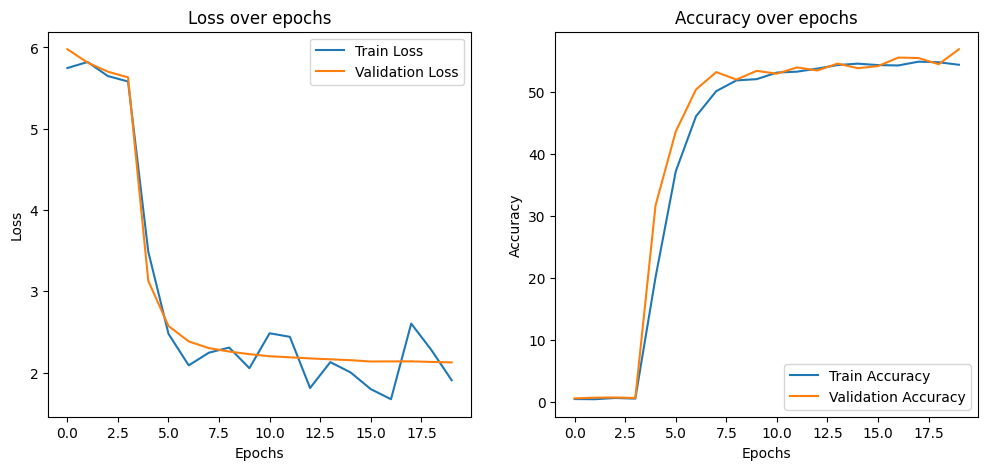

In [ ]:
plot_img(history)


## Simple CNN (epoch=20, learning rate = 0.01) / 100000 samples

In [ ]:
history_3, model_3 = SimpleCNNRun(num_epochs=20, lr=0.01)

Epoch 1: Train Loss: 2.1446, Validation Loss: 2.3599, Validation Accuracy: 36.29%
Epoch 2: Train Loss: 2.4667, Validation Loss: 2.1446, Validation Accuracy: 55.20%
Epoch 3: Train Loss: 2.3330, Validation Loss: 2.1354, Validation Accuracy: 54.77%
Epoch 4: Train Loss: 1.8818, Validation Loss: 2.1372, Validation Accuracy: 53.36%
Epoch 5: Train Loss: 2.0282, Validation Loss: 2.1249, Validation Accuracy: 54.54%
Epoch 6: Train Loss: 2.5704, Validation Loss: 2.1305, Validation Accuracy: 55.54%
Epoch 7: Train Loss: 2.1753, Validation Loss: 2.1288, Validation Accuracy: 56.21%
Epoch 8: Train Loss: 2.0904, Validation Loss: 2.1224, Validation Accuracy: 54.93%
Epoch 9: Train Loss: 2.5318, Validation Loss: 2.1255, Validation Accuracy: 54.40%
Epoch 10: Train Loss: 2.0963, Validation Loss: 2.1239, Validation Accuracy: 54.37%
Epoch 11: Train Loss: 1.9689, Validation Loss: 2.1267, Validation Accuracy: 54.45%
Epoch 12: Train Loss: 2.3283, Validation Loss: 2.1253, Validation Accuracy: 55.69%
Epoch 13: Tra

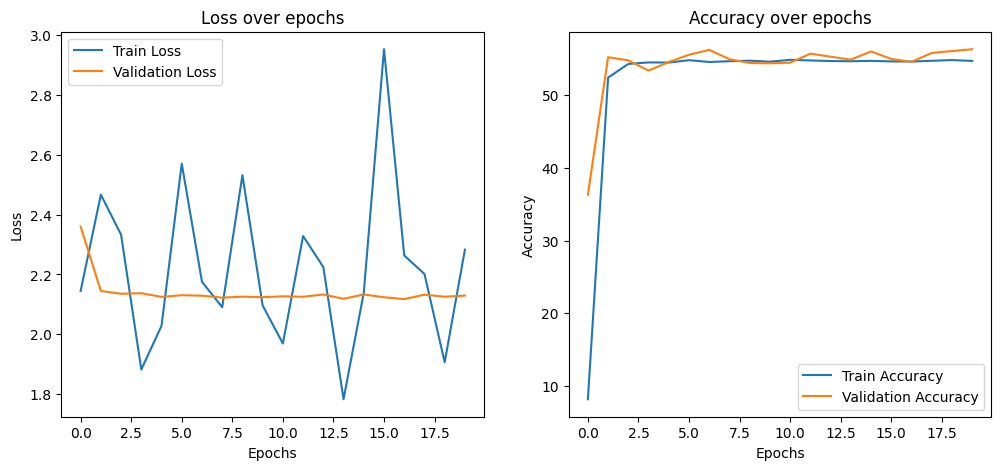

In [ ]:
plot_img(history)

## Simple CNN (epoch=20, learning rate = 0.03) / 10000 samples

In [ ]:
history_1, model_1 = SimpleCNNRun(num_epochs=20, lr=0.03)

Epoch 1: Train Loss: 5.6726, Validation Loss: 5.7372, Validation Accuracy: 0.50%
Epoch 2: Train Loss: 2.3171, Validation Loss: 2.5925, Validation Accuracy: 41.05%
Epoch 3: Train Loss: 2.2914, Validation Loss: 2.3127, Validation Accuracy: 51.35%
Epoch 4: Train Loss: 2.2899, Validation Loss: 2.2215, Validation Accuracy: 52.48%
Epoch 5: Train Loss: 2.1015, Validation Loss: 2.1879, Validation Accuracy: 53.09%
Epoch 6: Train Loss: 1.7133, Validation Loss: 2.1749, Validation Accuracy: 55.61%
Epoch 7: Train Loss: 2.7138, Validation Loss: 2.1651, Validation Accuracy: 52.50%
Epoch 8: Train Loss: 2.0838, Validation Loss: 2.1606, Validation Accuracy: 55.72%
Epoch 9: Train Loss: 1.6998, Validation Loss: 2.1397, Validation Accuracy: 53.83%
Epoch 10: Train Loss: 2.1930, Validation Loss: 2.1461, Validation Accuracy: 55.35%
Epoch 11: Train Loss: 1.8929, Validation Loss: 2.1297, Validation Accuracy: 53.91%
Epoch 12: Train Loss: 2.4907, Validation Loss: 2.1302, Validation Accuracy: 54.77%
Epoch 13: Trai

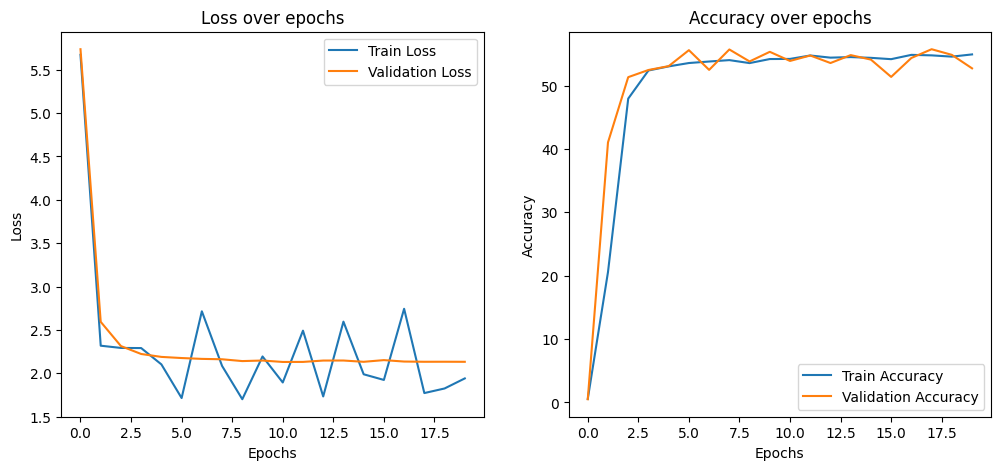

In [ ]:
plot_img(history_2)

## Simple CNN (epoch=20, learning rate = 0.03, betas = (0.85, 0.9)) / 10000 samples

In [ ]:
history_4, model_4 = SimpleCNNRun(num_epochs=20, lr=0.03, betas=(0.85,0.9))

Epoch 1: Train Loss: 2.5443, Validation Loss: 2.5179, Validation Accuracy: 42.19%
Epoch 2: Train Loss: 1.9436, Validation Loss: 2.1694, Validation Accuracy: 53.79%
Epoch 3: Train Loss: 1.7533, Validation Loss: 2.1484, Validation Accuracy: 50.91%
Epoch 4: Train Loss: 2.7559, Validation Loss: 2.1138, Validation Accuracy: 56.19%
Epoch 5: Train Loss: 1.8805, Validation Loss: 2.1113, Validation Accuracy: 54.45%
Epoch 6: Train Loss: 2.2892, Validation Loss: 2.1209, Validation Accuracy: 57.12%
Epoch 7: Train Loss: 2.3321, Validation Loss: 2.1105, Validation Accuracy: 56.39%
Epoch 8: Train Loss: 2.3183, Validation Loss: 2.1113, Validation Accuracy: 53.43%
Epoch 9: Train Loss: 1.9626, Validation Loss: 2.1139, Validation Accuracy: 57.20%
Epoch 10: Train Loss: 2.1040, Validation Loss: 2.1145, Validation Accuracy: 55.75%
Epoch 11: Train Loss: 2.3018, Validation Loss: 2.1157, Validation Accuracy: 55.27%
Epoch 12: Train Loss: 2.3308, Validation Loss: 2.1168, Validation Accuracy: 54.33%
Epoch 13: Tra

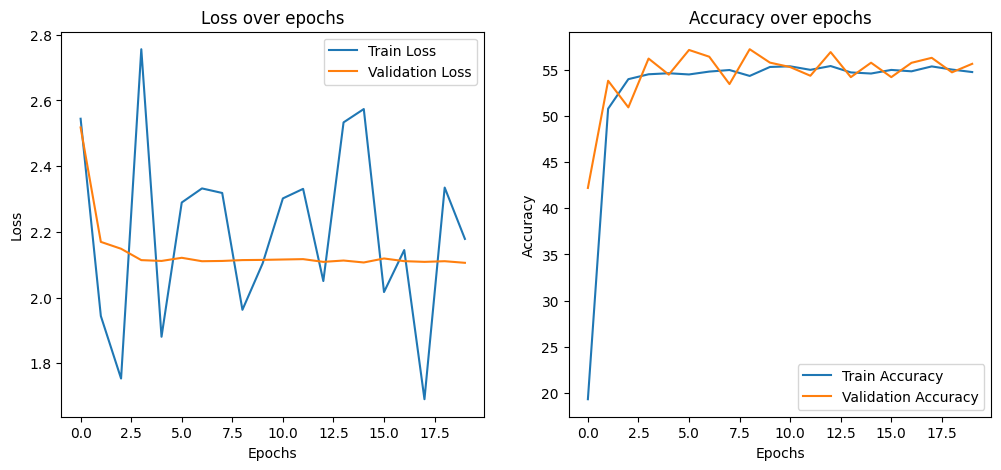

In [ ]:
plot_img(history_4)

## Simple CNN (epoch=20, learning rate = 0.01, betas = (0.85, 0.9)) / 10000 samples batch size 64

In [ ]:
# Currently a subset of the complete dataset
batch_size = 64
val_dataloader = DataLoader(val_subset_dataset, batch_size=batch_size, shuffle=False)
train_dataloader = DataLoader(train_subset_dataset, batch_size=batch_size, shuffle=True)

history_5, model_5 = SimpleCNNRun(num_epochs=20, lr=0.01, betas=(0.85,0.9))

Epoch 1: Train Loss: 5.2467, Validation Loss: 5.3385, Validation Accuracy: 2.04%
Epoch 2: Train Loss: 3.7329, Validation Loss: 4.3316, Validation Accuracy: 4.25%
Epoch 3: Train Loss: 3.3421, Validation Loss: 3.6455, Validation Accuracy: 6.18%
Epoch 4: Train Loss: 3.3273, Validation Loss: 3.2797, Validation Accuracy: 6.33%
Epoch 5: Train Loss: 2.8411, Validation Loss: 3.0782, Validation Accuracy: 6.06%
Epoch 6: Train Loss: 2.8818, Validation Loss: 2.9686, Validation Accuracy: 6.48%
Epoch 7: Train Loss: 2.7400, Validation Loss: 2.6970, Validation Accuracy: 21.02%
Epoch 8: Train Loss: 2.4542, Validation Loss: 2.3921, Validation Accuracy: 33.44%
Epoch 9: Train Loss: 2.1992, Validation Loss: 2.2418, Validation Accuracy: 45.47%
Epoch 10: Train Loss: 1.7176, Validation Loss: 2.1757, Validation Accuracy: 52.22%
Epoch 11: Train Loss: 2.0498, Validation Loss: 2.1476, Validation Accuracy: 54.20%
Epoch 12: Train Loss: 2.4035, Validation Loss: 2.1374, Validation Accuracy: 56.34%
Epoch 13: Train Los

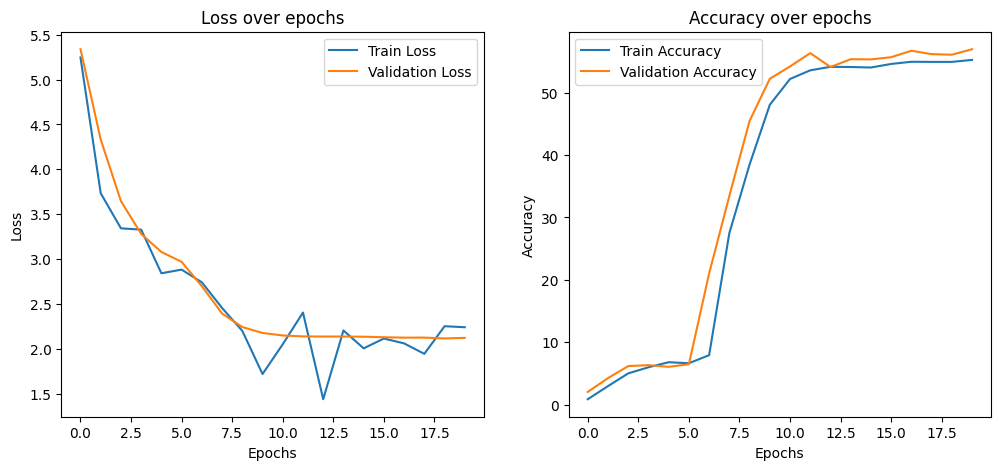

In [ ]:
plot_img(history_5)

## Another CNN (with more convolution)

This next network defines a more complex Convolutional Neural Network (CNN) architecture called SimpleCCNet using PyTorch. This CNN consists of multiple convolutional layers, max pooling layers, and fully connected layers, which allows it to learn hierarchical features from input images and make predictions.
The SimpleCCNet class inherits from PyTorch's nn.Module, which is the base class for all neural network modules in PyTorch.

The forward method defines the forward pass of the network, specifying how the input tensor flows through the layers. The input tensor undergoes a series of convolutions, ReLU activations, and max pooling operations. The resulting feature maps are then flattened and passed through the fully connected layers, which apply non-linear transformations and produce the final output.

Dropout regularization is applied after the first fully connected layer to prevent overfitting and improve generalization. Dropout randomly sets a fraction of the input units to zero during training, which helps the network learn more robust features.
The specific architecture of this CNN suggests that it is designed for a binary classification task, as the final fully connected layer has an output size of 2. The network takes an input image, processes it through the convolutional and fully connected layers, and produces a prediction indicating the class probabilities.

This code serves as a starting point for building a CNN model and can be further customized and optimized based on the specific requirements of the task at hand. By modifying the number and size of the layers, adjusting the hyperparameters, and incorporating additional techniques such as batch normalization or data augmentation, the performance of the network can be enhanced.

In [ ]:
class SimpleCCNet(nn.Module):
    def __init__(self):
        super(SimpleCCNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)
        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        #x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:


def AnotherCNNRun(num_epochs=10, lr=0.001, momentum=0.9):
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }
    # Assume the model is already defined
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_cn = SimpleCCNet().to(device)
    criterion =  nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_cn.parameters(), lr=lr, momentum=momentum)


    for epoch in range(num_epochs):
        train_loss = 0
        correct = 0
        total = 0

        # Training part as detailed previously
        model_cn.train()
        for i, (images, labels) in  enumerate(train_dataloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model_cn(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # for train
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


        train_loss /= len(train_dataloader)
        train_accuracy = 100 * correct / total


        # Validation part
        val_loss, val_accuracy = validate(model, val_dataloader, criterion, device)

        # Save metrics to the dictionary
        history['train_loss'].append(loss.item())
        history['train_accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f'Epoch {epoch+1}: Train Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    return history, model

In [ ]:
# Currently a subset of the complete dataset
batch_size = 128
val_dataloader = DataLoader(val_subset_dataset, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(train_subset_dataset, batch_size=batch_size, shuffle=True)


history, model = AnotherCNNRun(num_epochs=10, lr=0.001, momentum=0.9)

Epoch 1: Train Loss: 0.6406, Validation Loss: 2.1332, Validation Accuracy: 56.94%
Epoch 2: Train Loss: 0.7032, Validation Loss: 2.1289, Validation Accuracy: 56.79%
Epoch 3: Train Loss: 0.6378, Validation Loss: 2.1356, Validation Accuracy: 56.57%
Epoch 4: Train Loss: 0.7033, Validation Loss: 2.1391, Validation Accuracy: 56.48%
Epoch 5: Train Loss: 0.7520, Validation Loss: 2.1337, Validation Accuracy: 56.56%
Epoch 6: Train Loss: 0.6467, Validation Loss: 2.1323, Validation Accuracy: 56.71%
Epoch 7: Train Loss: 0.7851, Validation Loss: 2.1262, Validation Accuracy: 56.61%
Epoch 8: Train Loss: 0.5993, Validation Loss: 2.1272, Validation Accuracy: 56.91%
Epoch 9: Train Loss: 0.6389, Validation Loss: 2.1327, Validation Accuracy: 56.62%
Epoch 10: Train Loss: 0.6868, Validation Loss: 2.1390, Validation Accuracy: 56.65%


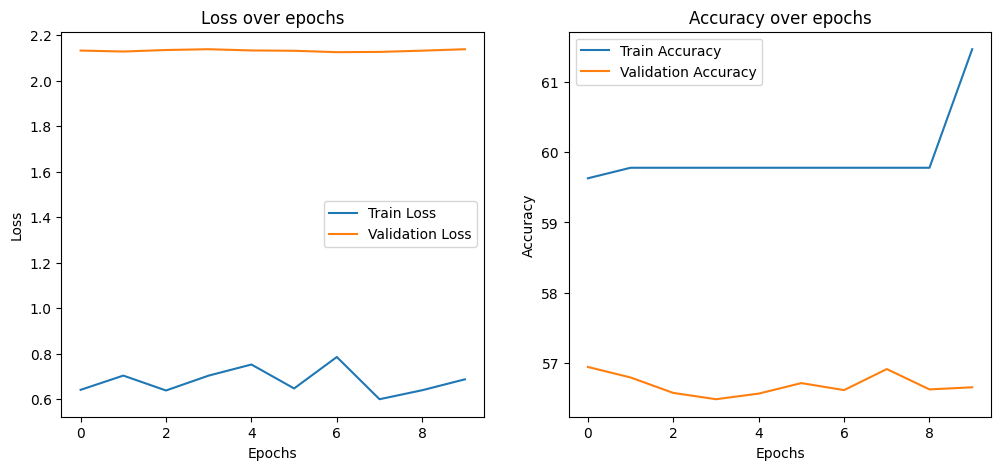

In [ ]:
plot_img(history)

# Another CNN

In [ ]:
history_acnn_1, model_acnn_1 = AnotherCNNRun(num_epochs=10, lr=0.01, momentum=0.9)

Epoch 1: Train Loss: 0.7391, Validation Loss: 2.1327, Validation Accuracy: 56.50%
Epoch 2: Train Loss: 0.5590, Validation Loss: 2.1346, Validation Accuracy: 56.68%
Epoch 3: Train Loss: 0.6838, Validation Loss: 2.1350, Validation Accuracy: 56.63%
Epoch 4: Train Loss: 0.4330, Validation Loss: 2.1319, Validation Accuracy: 56.82%
Epoch 5: Train Loss: 0.3642, Validation Loss: 2.1351, Validation Accuracy: 56.62%
Epoch 6: Train Loss: 0.6128, Validation Loss: 2.1264, Validation Accuracy: 56.74%
Epoch 7: Train Loss: 0.3800, Validation Loss: 2.1332, Validation Accuracy: 56.82%
Epoch 8: Train Loss: 0.4077, Validation Loss: 2.1307, Validation Accuracy: 56.60%
Epoch 9: Train Loss: 0.2635, Validation Loss: 2.1324, Validation Accuracy: 56.50%
Epoch 10: Train Loss: 0.5692, Validation Loss: 2.1379, Validation Accuracy: 56.80%


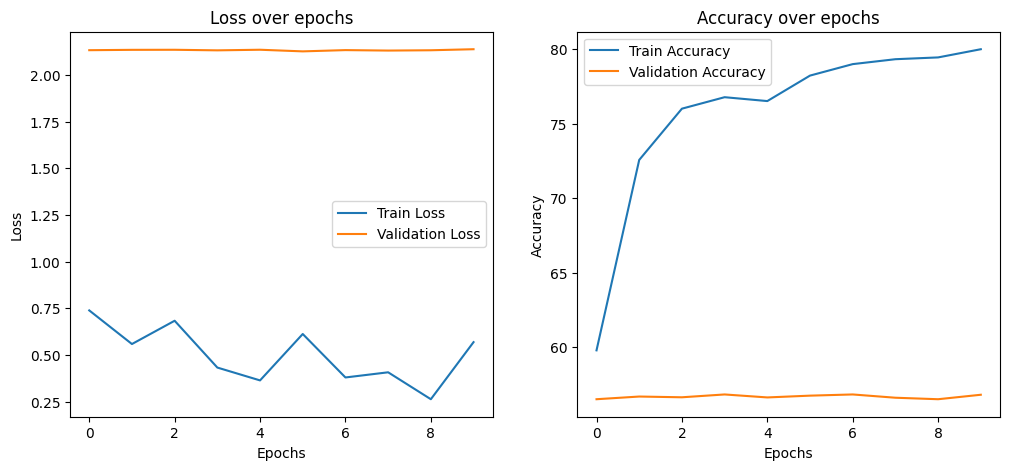

In [ ]:
plot_img(history_acnn_1)

## Submission for Kaggle

In [ ]:
model_cn.eval()
preds = []
for batch_i, (data, target) in enumerate(test_dataloader):
    data, target = data.cuda(), target.cuda()
    output = model_cn(data)

    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)

In [ ]:

test_preds = pd.DataFrame({'imgs': test_dataset.image_files_list, 'preds': preds})
test_preds['imgs'] = test_preds['imgs'].apply(lambda x: x.split('.')[0])
sub = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
sub = pd.merge(sub, test_preds, left_on='id', right_on='imgs')
sub = sub[['id', 'preds']]
sub.columns = ['id', 'label']
sub.head()


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,-0.707544
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.320652
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,-1.107251
3,2c35657e312966e9294eac6841726ff3a748febf,-0.597856
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,-0.436824


In [ ]:
sub.to_csv('sub.csv', index=False)


## Results and Analysis

| CNN |  epochs | LR | Val Accuracy | Samples |  Beta | Batch |
| --- | --- | --- | --- |  --- | --- | --- |
| Simple CNN | 20 | 0.01 | 56.89% | 100,000| (0.9, 0.999) | 32 |
| Simple CNN | 20 | 0.01 | 56.30% | 10,000|(0.9, 0.999) | 32 |
| Simple CNN | 20 | 0.03 | 55.76% | 10,000|(0.9, 0.999) | 32 |
| Simple CNN | 20 | 0.03 | 57.2% | 10,000|(0.85, 0.9) | 32 |
| Simple CNN | 20 | 0.01 | 56.96% | 10,000|(0.85, 0.9) | 64 |
| Another Simple CNN | 10 | 0.001 | 56.91% | 10,000| - | 128 |
| Another Simple CNN | 10 | 0.01 | 56.8% | 10,000| - | 128 |

The table presents the results of experiments conducted using two different Convolutional Neural Network (CNN) architectures, namely "Simple CNN" and "Another Simple CNN," on a binary classification task. The experiments aim to evaluate the impact of various hyperparameters on the model's performance, specifically the validation accuracy.

For the "Simple CNN" architecture, the experiments explore different combinations of learning rate (LR), number of training samples, and beta values for the optimizer. The results show that increasing the learning rate from 0.01 to 0.03 leads to a slight decrease in validation accuracy when using 10,000 training samples and beta values of (0.9, 0.999). However, changing the beta values to (0.85, 0.9) and keeping the learning rate at 0.03 improves the validation accuracy to 57.2%. Additionally, increasing the batch size from 32 to 64 while using a learning rate of 0.01 and beta values of (0.85, 0.9) results in a validation accuracy of 56.96%.

The experiments with the "Another Simple CNN" architecture focus on the impact of learning rate and batch size. Using a learning rate of 0.001 and a batch size of 128 achieves a validation accuracy of 56.91%. Increasing the learning rate to 0.01 while keeping the batch size the same leads to a slightly lower validation accuracy of 56.8%.

Overall, the results suggest that the choice of hyperparameters, such as learning rate, beta values, and batch size, can influence the performance of the CNN models. However, the differences in validation accuracy across the experiments are relatively small, indicating that the models' performance is somewhat robust to variations in these hyperparameters within the tested ranges. It is important to note that the highest validation accuracy achieved is 57.2%, which suggests that further improvements to the model architecture, data preprocessing, or other aspects may be necessary to achieve better performance on the given binary classification task.



## Conclusion
Based on the experimental results presented in the table, we can draw several insights and learnings regarding the performance of the CNN models on the binary classification task.

Interpretation of Results:
The experiments demonstrate that the choice of hyperparameters can have an impact on the model's performance, although the differences in validation accuracy are relatively small. The "Simple CNN" architecture achieves validation accuracies ranging from 55.76% to 57.2%, while the "Another Simple CNN" architecture achieves validation accuracies of 56.91% and 56.8%.

**Learnings and Takeaways:**
1. Learning Rate: Increasing the learning rate from 0.01 to 0.03 in the "Simple CNN" architecture led to a slight decrease in validation accuracy when using 10,000 training samples and beta values of (0.9, 0.999). This suggests that a higher learning rate may not always lead to better performance and that finding the optimal learning rate is important.

2. Beta Values: Changing the beta values from (0.9, 0.999) to (0.85, 0.9) in the "Simple CNN" architecture, while keeping the learning rate at 0.03, improved the validation accuracy to 57.2%. This indicates that the choice of beta values for the optimizer can have an impact on the model's performance.

3. Batch Size: Increasing the batch size from 32 to 64 in the "Simple CNN" architecture, while using a learning rate of 0.01 and beta values of (0.85, 0.9), resulted in a validation accuracy of 56.96%. This suggests that the batch size can influence the model's performance, but the impact may be limited.

4. Training Samples: The "Simple CNN" architecture achieved a validation accuracy of 56.89% when trained on 100,000 samples, compared to 56.30% when trained on 10,000 samples. This indicates that increasing the number of training samples can potentially improve the model's performance.

**What Did and Did Not Help:**
- Adjusting the beta values for the optimizer helped improve the performance of the "Simple CNN" architecture, as seen in the experiment with beta values of (0.85, 0.9) and a learning rate of 0.03.
- Increasing the learning rate from 0.01 to 0.03 did not consistently improve performance and even led to a slight decrease in some cases.
- Increasing the batch size from 32 to 64 had a limited impact on the model's performance.
- Training on a larger dataset of 100,000 samples helped improve the validation accuracy compared to training on 10,000 samples.

**Potential Improvements for the Future:**
1. Architecture Refinement: Experiment with different CNN architectures or modify the existing architectures by adding more layers, increasing the number of filters, or incorporating techniques like skip connections or attention mechanisms.

2. Hyperparameter Tuning: Conduct more extensive hyperparameter tuning using techniques like grid search or random search to find the optimal combination of learning rate, beta values, batch size, and other hyperparameters.

3. Data Augmentation: Apply data augmentation techniques such as rotation, flipping, scaling, or adding noise to the training data to increase the diversity of the samples and improve the model's ability to generalize.

4. Transfer Learning: Leverage pre-trained models or architectures that have been successful in similar tasks and fine-tune them on the specific binary classification problem at hand.

5. Ensemble Methods: Train multiple models with different architectures or hyperparameters and combine their predictions using ensemble techniques like voting or averaging to improve the overall performance.

6. Regularization Techniques: Implement regularization techniques such as L1/L2 regularization, dropout, or early stopping to prevent overfitting and improve the model's generalization ability.

By exploring these improvements and conducting further experiments, it may be possible to enhance the performance of the CNN models on the binary classification task.

## References

1. B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". arXiv:1806.03962

2. "Simple EDA and model in pytorch" https://www.kaggle.com/code/artgor/simple-eda-and-model-in-pytorch

3. A complete ML pipeline (Fast.ai) https://www.kaggle.com/code/qitvision/a-complete-ml-pipeline-fast-ai